<a href="https://colab.research.google.com/github/MihaiDogariu/Keysight-Deep-Learning-Fundamentals/blob/main/Unit%20%239%20-%20Variational%20Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders
In this notebook we will study how the variational autoencoder works and implement some particular cases of it.

The structure of a variational autoencoder is as shown in Figure 1.
<div>
  <center>
    <img src="https://drive.google.com/uc?export=view&id=19xaohSDC69CnfsICxrGF5dLaMbZk3aPI" width="400" class="center">
    <p>Figure 1. General structure of a variational autoencoder.</p>
  </center>
</div>

The variational autoencoder is a particular case of an autoencoder that specializes in generating new samples. It consists of 2 subassemblies, like the autoencoder:
- encoder - transforms the input sample into a latent descriptor: $h=f(x)$
- decoder - turns the latent descriptor into a sample: $r=g(h)=g(f(x))$. Ideally, $g(x) = f^{-1}(x)$, such that $r=x$.

Unlike the autoencoder, obtaining $h=f(x)$ is not done directly from traversing the neural network, but an additional sampling step is required. Each value $h$ is obtained as a sample drawn from the probability distribution $\mathcal{N}(\mu, \sigma^2)$, where $\mu$ represents the mean of the distribution and $\sigma$ the standard deviation, both being entities that can be learned by the VAE. The problem arises when a random sample is drawn from this distribution, as this is a non-deterministic process and cannot be learned (one cannot compute and propagate the gradient for a random operation). Therefore, a reparameterization technique is resorted to, which moves the random component outside the network, as in Figure 2.
<div>
  <center>
    <img src="https://drive.google.com/uc?export=view&id=1WaM5AN4l21xHikF3HqStoS7RKUjsmuod" width="500" class="center">
    <p>Figure 2. General structure of a variational autoencoder.</p>
  </center>
</div>

In this way, $h$ is still obtained as a sample drawn from the probability distribution $\mathcal{N}(\mu, \sigma^2)$, but it is reparameterized in $\mu+\sigma\times\varepsilon$ , with $\varepsilon\sim\mathcal{N}(0, I)$.

VAE training is done by minimizing the cost function:

$\mathcal{L}=Loss_{reconstruction}+Loss_{similarity}$, where

$Loss_{reconstruction}=\mathbb{E}_{q_\phi}[\log{p_\theta(x|z))}]$

$Loss_{similarity}=-D_{KL}(q_\phi(z)||p(z))$

In [1]:
import sys

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

# Setting hyperparameters

In [2]:
latent_dims = 2
# latent_dims = 10
num_epochs = 30
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1

#Downloading and preparing the MNIST Digits dataset

In [3]:
# Downloading the MNIST dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15748041.42it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 223532.23it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3668822.26it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9626340.96it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



# Defininf the VAE model

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims) # mu represents the mean vector
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims) # logvar represents the variance vector

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # using sigmoid because of the BCE cost function
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_reconstruit = self.decoder(latent)
        return x_reconstruit, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # reparametrization
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(x_reconstruit, x, mu, logvar):
    loss_reconstructie = F.binary_cross_entropy(x_reconstruit.view(-1, 784), x.view(-1, 784), reduction='sum')
    loss_similaritate = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # Kullback-Leibler divergence
    return loss_reconstructie + variational_beta * loss_similaritate # variational_beta is a parameter that controls the weight of the 2 components in the final loss

In [5]:
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae = vae.to(device)

# Training the VAE

In [6]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device)

        # the reconstruction x -> encoder -> h -> decoder -> x_reconstruit
        image_batch_reconstruit, latent_mu, latent_logvar = vae(image_batch)

        # variational error (Evidence Lower Bound - ELBO)
        loss = vae_loss(image_batch_reconstruit, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # weights update
        optimizer.step()

        # acumularea the error at each iteration
        train_loss_avg[-1] += loss.item()
        num_batches += 1

    # averaging the loss on the entire epoch
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 30] average reconstruction error: 24002.792819
Epoch [2 / 30] average reconstruction error: 21148.170176
Epoch [3 / 30] average reconstruction error: 20573.657537
Epoch [4 / 30] average reconstruction error: 20275.659498
Epoch [5 / 30] average reconstruction error: 20068.706540
Epoch [6 / 30] average reconstruction error: 19931.444413
Epoch [7 / 30] average reconstruction error: 19819.653020
Epoch [8 / 30] average reconstruction error: 19731.338909
Epoch [9 / 30] average reconstruction error: 19649.247587
Epoch [10 / 30] average reconstruction error: 19586.080709
Epoch [11 / 30] average reconstruction error: 19526.821593
Epoch [12 / 30] average reconstruction error: 19478.138709
Epoch [13 / 30] average reconstruction error: 19424.120548
Epoch [14 / 30] average reconstruction error: 19386.005401
Epoch [15 / 30] average reconstruction error: 19350.935260
Epoch [16 / 30] average reconstruction error: 19313.154297
Epoch [17 / 30] average reconstruction error: 19274.

# Display the training error curve

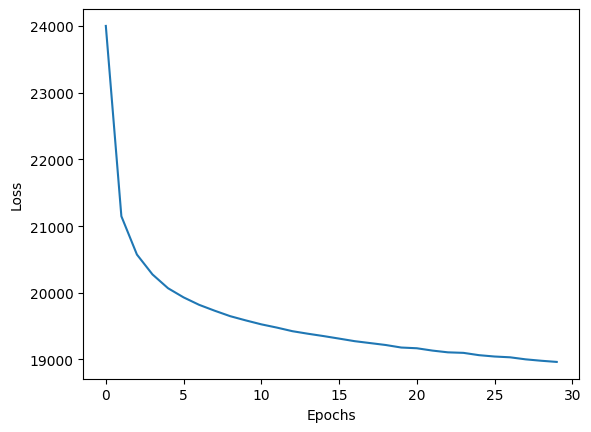

In [7]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluating on the test set

In [8]:
# Setting the VAE in eval mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # VAE reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # Variational error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19043.726077


# Visualizing the reconstruction

Original Images


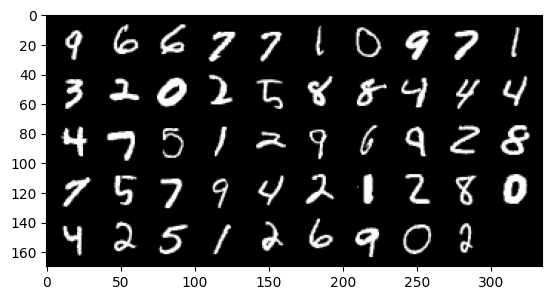

Images reconstructed by VAE


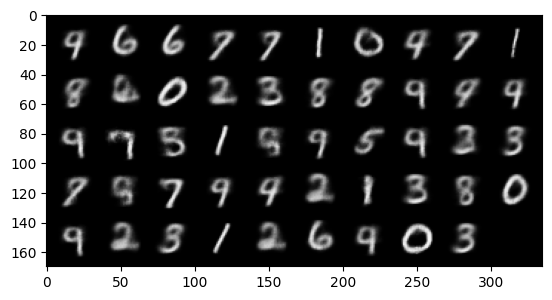

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

def to_img(x):
    x = x.clamp(0, 1) # some values might fall outside the [0, 1] interval
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# Displaying the original images
print('Original Images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Displaying the VAE-reconstructed images
print('Images reconstructed by VAE')
visualise_output(images, vae)

# Using VAE to generate new samples

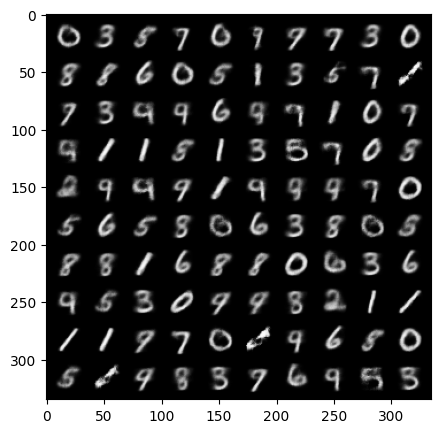

In [10]:
vae.eval()

with torch.no_grad():

    # sampling latent vectors from the latent distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstructing images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

# Latent space interpolation

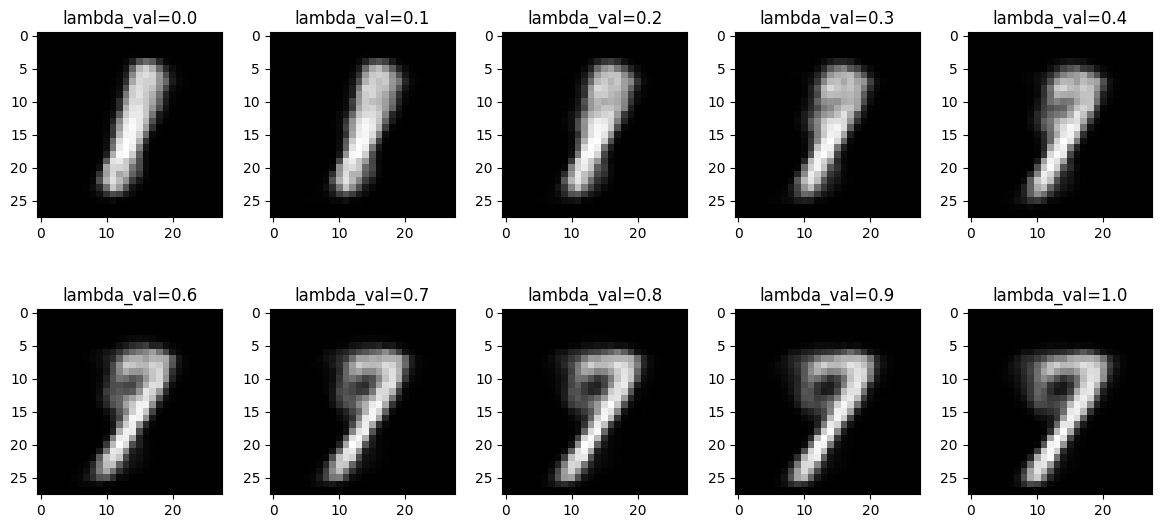

In [11]:
vae.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of the first sample
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of the second sample
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolate between the 2 latent vectors with a factor of lambda, controlling the interpolation step
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # interpolated sample reconstruction
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sorting images according to the number that they represent
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# computing lambda parameters - the third arguments shows us the number of interpolation steps that we are going to take
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

# Displaying the 2D latent space

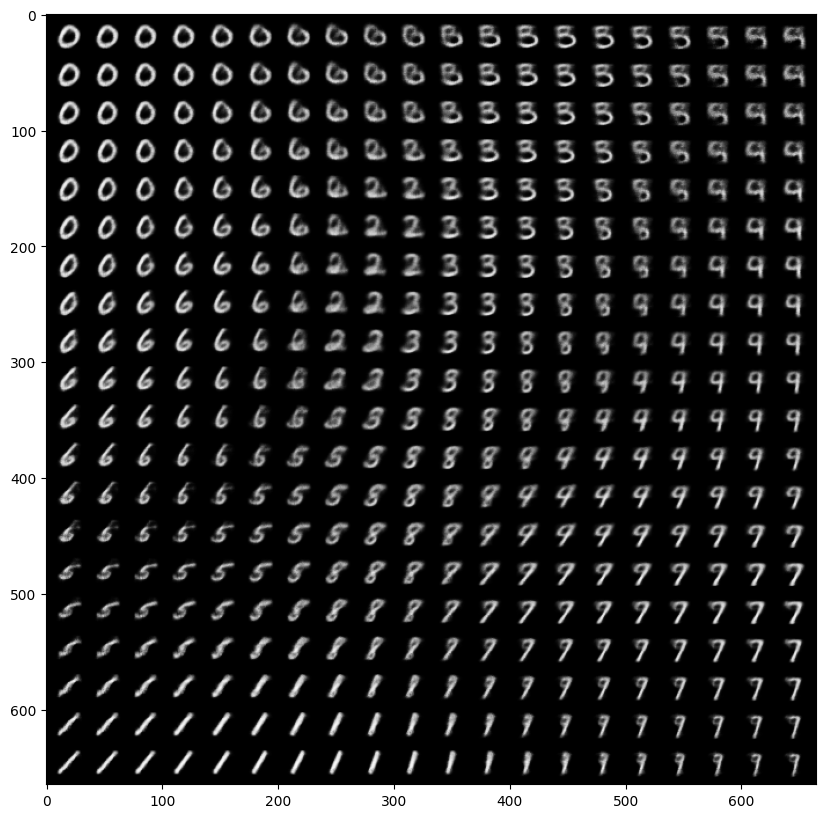

In [12]:
# This has sense only if the latent space dimension is equal to 2
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # creating a 2D space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten in batch

    # image reconstruction from latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()